# Core Imports and Setup

In [ ]:
import os, re, glob
from pathlib import Path
from os import listdir
import numpy as np
from scipy.stats import linregress, zscore, pearsonr
from sklearn.metrics import mean_squared_error
from openff.evaluator.datasets import PhysicalPropertyDataSet

from openff.evaluator.forcefield import SmirnoffForceFieldSource
from openff.toolkit import ForceField

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot

import matplotlib.pyplot as plt


# Loading ThermoML Data Sets

## Extracting data from ThermoML

In [2]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
initial_df=data_set_initial.to_pandas()

In [3]:
# initial_df.to_csv(f'data_set_initial.csv')

In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'EnthalpyOfMixing', 'Density'}
{<Substance CN1CCNCC1{solv}{x=0.510900}|O{solv}{x=0.489100}>, <Substance CN(C)CCO{solv}{x=0.536500}|O{solv}{x=0.463500}>, <Substance OC1=NCCC1{solv}{x=0.500000}|O{solv}{x=0.500000}>, <Substance CN1CCOCC1{solv}{x=0.498300}|O{solv}{x=0.501700}>, <Substance NCCCO{solv}{x=0.272809}|O{solv}{x=0.727191}>, <Substance OCCN(CCO)CCO{solv}{x=0.206300}|O{solv}{x=0.793700}>, <Substance NCCNCCO{solv}{x=0.770000}|O{solv}{x=0.230000}>, <Substance NCCCO{solv}{x=0.489642}|O{solv}{x=0.510358}>, <Substance CCN(CC)CCO{solv}{x=0.200800}|O{solv}{x=0.799200}>, <Substance CN1CCNCC1{solv}{x=0.550000}|O{solv}{x=0.450000}>, <Substance OCCN(CCO)CCO{solv}{x=0.710000}|O{solv}{x=0.290000}>, <Substance Cc1cccnc1{solv}{x=0.700000}|O{solv}{x=0.300000}>, <Substance CNCCO{solv}{x=0.501700}|O{solv}{x=0.498300}>, <Substance NCCCNCCCN{solv}{x=0.300500}|O{solv}{x=0.699500}>, <Substance C1COCCN1{solv}{x=0.714900}|O{solv}{x=0.285100}>, <Substance CN1CCCCC1{solv}{x=0.245200}|O{solv}{x=0.754800

## Filtering data set

In [5]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog
from openff.evaluator.substances import Component, Substance

In [6]:
subs=list(set(data_set_initial.substances))
smiles_list=[]

for i in subs:
    comps=[]
    comps.append(i.components[0].smiles)
    comps.append(i.components[1].smiles)
    for o in comps:
        comps.remove('O')
        [smiles_list.append(y) for y in comps]

print(len(smiles_list))

120


In [7]:
def get_func_smiles(smiles_list):
    mols_list=[]

    for s in smiles_list:
        m=Chem.MolFromSmiles(s)
        mols_list.append(m)

    alcohols=[]
    amines=[]
    both=[]
    other=[]
    
    fc = FilterCatalog.GetFunctionalGroupHierarchy()
    for i in range(len(mols_list)):
        whtv=mols_list[i]
        if not fc.GetMatches(whtv):
            other.append(i)
        else:
            for match in fc.GetMatches(whtv):
                ffg=match.GetDescription()
                # print(i,ffg)
                if ffg == 'Amine':
                    amines.append(i)
                elif ffg == 'Alcohol':
                    alcohols.append(i)
                if i in amines and i in alcohols:
                    both.append(i)
                    amines.remove(i)
                    alcohols.remove(i)
    

    def get_smiles(func_type):
        smiles=[]

        for x in func_type:
            comp0=subs[x].components[0].smiles
            comp1=subs[x].components[1].smiles
            if comp0 != 'O':
                smiles.append(comp0)
            if comp1 != 'O':
                smiles.append(comp1)
            # smiles.append(comp0) 
            # smiles.append(comp1)
        smiles.append('O')
        return smiles

    smiles_results={}

    smiles_results['all']=smiles_list
    smiles_results['alcohols']=get_smiles(alcohols)
    smiles_results['amines']=get_smiles(amines)
    smiles_results['both']=get_smiles(both)
    smiles_results['other']=get_smiles(other)

    return smiles_results

    

In [8]:
smiles_results=get_func_smiles(smiles_list)

In [9]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

data_set_alcohols= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['alcohols']))

print(len(data_set_alcohols))

data_set_amines= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['amines']))

print(len(data_set_amines))

data_set_both= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['both']))

print(len(data_set_both))

data_set_other= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['other']))

print(len(data_set_other))

123
18
33
62
10


In [10]:
print(set(smiles_results['all']))

{'OCCN(CCO)CCO', 'Cn1ccnc1', 'OCC(O)CO', 'CN(C)CCO', 'CCN(CC)CCO', 'Cc1ccncc1', 'CN1CCOCC1', 'Cc1cccnc1', 'CN1CCNCC1', 'CN1CCCCC1', 'NCCCNCCCN', 'CC(C)O', 'OC1=NCCC1', 'NCCNCCO', 'CCCOC(C)=O', 'CN(C)CCCO', 'OCCN1CCOCC1', 'C1COCCN1', 'C1CCNCC1', 'CNCCO', 'OCCNCCO', 'NCCNCCN', 'NCCCO', 'OCCOCCO', 'CN(CCO)CCO'}


In [11]:
# # save for future use

path=os.getcwd()

path_all=path+'/filtered_dataset_all.json'
data_set_hmix_dens.json(path_all, format=True)

# path_alcohols = path+'/filtered_dataset_alcohols.json'
# data_set_alcohols.json(path_alcohols, format=True)

# path_amines = path+'/filtered_dataset_amines.json'
# data_set_amines.json(path_amines, format=True)

# path_both = path+'/filtered_dataset_both.json'
# data_set_both.json(path_both, format=True)

# path_other = path+'/filtered_dataset_other.json'
# data_set_other.json(path_other, format=True)


# # inspect new properties
pandas_all = data_set_hmix_dens.to_pandas()
# pandas_alcohols = data_set_alcohols.to_pandas()
# pandas_amines = data_set_amines.to_pandas()
# pandas_both = data_set_both.to_pandas()
# pandas_other = data_set_other.to_pandas()

# Analysing Data Sets

In [12]:
force_field=['Sage2.2.1','Sage2.3.0']

### Plotting results all together

In [ ]:
def analysis_all(
    phys_prop: str,
    water_model: str,                 # e.g. "OPC"
    functional_group: str,            # e.g. "all"
    base_dir: str = "watermix_analysis_reps",
    ff: str = f'{force_field}',
    aggregate: str = "mean",          # "mean" or "median"
    n_boot: int = 1000,               # bootstraps for CI
):
    """
    Loads experimental values and multiple replicate result files, aligns them,
    computes per-replicate and aggregate stats vs experimental, and computes
    pairwise RMSE between replicates (with bootstrap CIs).

    Returns a dict with legacy plotting keys preserved, plus additional RMSE fields.
    """

    # ---------- helpers ----------
    def to_value(x, target_unit=None):
        if hasattr(x, "to"):
            try:
                return x.to(target_unit).magnitude if target_unit is not None else getattr(x, "magnitude", float(x))
            except Exception:
                return getattr(x, "magnitude", float(x))
        return float(x)

    def rmse_and_ci(x, y, n_boot=1000):
        """RMSE and 95% CI via bootstrap over matched indices."""
        x = np.asarray(x, float); y = np.asarray(y, float)
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        n = x.size
        if n == 0:
            return np.nan, (np.nan, np.nan), 0
        rmse_val = float(np.sqrt(mean_squared_error(x, y)))
        if n < 2 or n_boot <= 1:
            return rmse_val, (np.nan, np.nan), n
        idx = np.arange(n)
        boots = []
        for _ in range(n_boot):
            b = np.random.choice(idx, size=n, replace=True)
            boots.append(float(np.sqrt(mean_squared_error(x[b], y[b]))))
        lo, hi = float(np.percentile(boots, 2.5)), float(np.percentile(boots, 97.5))
        return rmse_val, (lo, hi), n

    def stats_vs_exp(x, y):
        """Regression, R², RMSE(+CI) vs experimental."""
        x = np.asarray(x, float); y = np.asarray(y, float)
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        if x.size < 2:
            return {
                "n": int(x.size), "slope": np.nan, "intercept": np.nan, "r_value": np.nan,
                "r2": np.nan, "r2_bounds": (np.nan, np.nan), "p_value": np.nan,
                "std_err": np.nan, "rmse": np.nan, "rmse_bounds": (np.nan, np.nan),
                "outliers": np.array([], dtype=int),
            }

        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        preds = intercept + slope * x
        residuals = y - preds
        zscores = np.abs(zscore(residuals, nan_policy='omit'))
        outliers = np.where(zscores > 2.5)[0]

        # R² via Pearson
        r, _ = pearsonr(x, y)
        r2 = (r ** 2) if not np.isnan(r) else 0.0

        rmse_val, rmse_ci, n_used = rmse_and_ci(x, y, n_boot=n_boot)

        # Bootstrap CI for R²
        if x.size >= 2 and n_boot > 1:
            idx = np.arange(x.size)
            r2_boot = []
            for _ in range(n_boot):
                b = np.random.choice(idx, size=x.size, replace=True)
                rb, _ = pearsonr(x[b], y[b])
                r2_boot.append((rb ** 2) if not np.isnan(rb) else 0.0)
            r2_bounds = (float(np.percentile(r2_boot, 2.5)), float(np.percentile(r2_boot, 97.5)))
        else:
            r2_bounds = (np.nan, np.nan)

        return {
            "n": int(n_used),
            "slope": float(slope), "intercept": float(intercept), "r_value": float(r_value),
            "r2": float(r2), "r2_bounds": r2_bounds,
            "p_value": float(p_value), "std_err": float(std_err),
            "rmse": float(rmse_val), "rmse_bounds": (float(rmse_ci[0]), float(rmse_ci[1])),
            "outliers": outliers,
        }

    # ---------- experimental ----------
    experimental_path = f"filtered_dataset_{functional_group}.json"
    exp_ds = PhysicalPropertyDataSet.from_json(experimental_path)
    exp_props = [p for p in exp_ds if type(p).__qualname__ == phys_prop]
    if not exp_props:
        print(f"No experimental '{phys_prop}' found in {experimental_path}")
        return {}

    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }
    prop_type      = exp_props[0].__class__.__name__
    fallback_unit  = getattr(exp_props[0].value, "units", None)
    preferred_unit = preferred_units.get(prop_type, fallback_unit)

    exp_ids  = [p.id for p in exp_props]
    exp_vals = [to_value(p.value, preferred_unit) for p in exp_props]

    # ---------- replicates ----------
    folder = (Path(base_dir).expanduser() / ff / water_model).resolve()
    rep_paths = sorted(
        glob.glob(str(folder / "results-r*.json")),
        key=lambda p: int(re.search(r"results-r(\d+)\.json$", os.path.basename(p)).group(1))
              if re.search(r"results-r(\d+)\.json$", os.path.basename(p)) else 10**9
    )
    if not rep_paths:
        print(f"No replicate files found in '{folder}' matching 'results-r*.json'.")
        print(f"  cwd: {os.getcwd()}")
        print(f"  folder exists? {folder.exists()}")
        return {}

    def load_est_map(path):
        ds = PhysicalPropertyDataSet.from_json(path)
        out = {}
        for est in getattr(ds, "estimated_properties", []):
            try:
                out[est.id] = to_value(est.value, preferred_unit)
            except Exception:
                pass
        return out

    rep_names, rep_vals = [], []
    for p in rep_paths:
        rep_names.append(os.path.basename(p))
        idmap = load_est_map(p)
        rep_vals.append([idmap.get(pid, np.nan) for pid in exp_ids])

    rep_arr = np.array(rep_vals, dtype=float)  # (n_reps, n_points)
    n_reps, _ = rep_arr.shape

    # Per-point replicate variability
    rep_counts = np.sum(np.isfinite(rep_arr), axis=0)
    rep_std = np.nanstd(rep_arr, axis=0, ddof=1)
    with np.errstate(invalid='ignore', divide='ignore'):
        rep_sem = rep_std / np.sqrt(rep_counts)

    # Aggregate across replicates
    agg_fn  = np.nanmedian if aggregate.lower() == "median" else np.nanmean
    agg_vec = agg_fn(rep_arr, axis=0)

    # Stats vs experimental
    agg_stats = stats_vs_exp(exp_vals, agg_vec)
    replicate_stats = {
        name: {"estimated_values": vals, "stats": stats_vs_exp(exp_vals, vals)}
        for name, vals in zip(rep_names, rep_arr.tolist())
    }

    # Pairwise RMSE between replicates (with CIs)
    pairwise_rmse = np.full((n_reps, n_reps), np.nan, dtype=float)
    pairwise_lo   = np.full((n_reps, n_reps), np.nan, dtype=float)
    pairwise_hi   = np.full((n_reps, n_reps), np.nan, dtype=float)
    pair_list = []
    for i in range(n_reps):
        pairwise_rmse[i, i] = 0.0
        for j in range(i + 1, n_reps):
            rmse_val, (lo, hi), n_used = rmse_and_ci(rep_arr[i], rep_arr[j], n_boot=n_boot)
            pairwise_rmse[i, j] = pairwise_rmse[j, i] = rmse_val
            pairwise_lo[i, j]   = pairwise_lo[j, i]   = lo
            pairwise_hi[i, j]   = pairwise_hi[j, i]   = hi
            pair_list.append({
                "rep_i": rep_names[i],
                "rep_j": rep_names[j],
                "n": int(n_used),
                "rmse": float(rmse_val),
                "rmse_bounds": (float(lo), float(hi)),
            })

    tril = np.tril_indices(n_reps, k=-1)
    pair_vals = pairwise_rmse[tril]
    pair_summary = {
        "n_pairs": int(np.sum(np.isfinite(pair_vals))),
        "mean_pairwise_rmse": float(np.nanmean(pair_vals)) if np.any(np.isfinite(pair_vals)) else np.nan,
        "median_pairwise_rmse": float(np.nanmedian(pair_vals)) if np.any(np.isfinite(pair_vals)) else np.nan,
        "min_pairwise_rmse": float(np.nanmin(pair_vals)) if np.any(np.isfinite(pair_vals)) else np.nan,
        "max_pairwise_rmse": float(np.nanmax(pair_vals)) if np.any(np.isfinite(pair_vals)) else np.nan,
    }

    # Quick summaries of replicate-vs-experimental RMSEs
    rmse_vs_exp_per_rep = [replicate_stats[n]["stats"]["rmse"] for n in rep_names]
    rmse_vs_exp_summary = {
        "mean_rmse_vs_exp": float(np.nanmean(rmse_vs_exp_per_rep)) if rmse_vs_exp_per_rep else np.nan,
        "median_rmse_vs_exp": float(np.nanmedian(rmse_vs_exp_per_rep)) if rmse_vs_exp_per_rep else np.nan,
        "min_rmse_vs_exp": float(np.nanmin(rmse_vs_exp_per_rep)) if rmse_vs_exp_per_rep else np.nan,
        "max_rmse_vs_exp": float(np.nanmax(rmse_vs_exp_per_rep)) if rmse_vs_exp_per_rep else np.nan,
    }

    # ---------- build output (legacy preserved) ----------
    out = {
        "meta": {
            "phys_prop": phys_prop,
            "water_model": water_model,
            "functional_group": functional_group,
            "unit": str(preferred_unit) if preferred_unit is not None else None,
            "replicate_files": rep_paths,
            "replicate_names": rep_names,
            "aggregate": aggregate.lower(),
            "folder": str(folder),
            "n_boot": n_boot,
        },
        "ids": exp_ids,
        "experimental_values": exp_vals,
        "aggregate_estimated_values": agg_vec.tolist(),
        "aggregate_stats": agg_stats,
        "replicates": replicate_stats,                 # per-replicate stats vs experimental
        "replicate_counts": rep_counts.tolist(),
        "replicate_std_values": rep_std.tolist(),
        "replicate_sem_values": rep_sem.tolist(),

        # Pairwise section (non-legacy, additive)
        "pairwise": {
            "rmse_matrix": pairwise_rmse.tolist(),
            "rmse_bounds_low_matrix": pairwise_lo.tolist(),
            "rmse_bounds_high_matrix": pairwise_hi.tolist(),
            "pairs": pair_list,
            "summary": pair_summary,
        },

        # Non-legacy summary
        "rmse_vs_experimental_summary": rmse_vs_exp_summary,
    }

    # ---------- legacy-style keys used by existing plotting code ----------
    out[f"{water_model}:{phys_prop}-Experimental_Values"] = exp_vals
    out[f"{water_model}:{phys_prop}-Estimated_Values"]    = agg_vec.tolist()
    out[f"{water_model}:{phys_prop}-Stats"]               = agg_stats
    out[f"{water_model}:{phys_prop}-Estimated_Std"]       = rep_std.tolist()
    out[f"{water_model}:{phys_prop}-Estimated_SEM"]       = rep_sem.tolist()

    # ---------- NEW: add convenient RMSE fields at the end (additive, won’t break plots) ----------
    out[f"{water_model}:{phys_prop}-RMSE_Aggregate_vs_Experimental"] = float(agg_stats["rmse"])
    out[f"{water_model}:{phys_prop}-RMSE_Aggregate_CI"] = tuple(map(float, agg_stats["rmse_bounds"]))

    # Per-replicate RMSE vs experimental as an ordered list (aligned to replicate_names)
    out[f"{water_model}:{phys_prop}-RMSE_PerReplicate_vs_Experimental"] = [
        float(replicate_stats[name]["stats"]["rmse"]) for name in rep_names
    ]
    out[f"{water_model}:{phys_prop}-RMSE_PerReplicate_CI"] = [
        tuple(map(float, replicate_stats[name]["stats"]["rmse_bounds"])) for name in rep_names
    ]

    # Pairwise RMSE convenience keys (matrix + summary)
    out[f"{water_model}:{phys_prop}-RMSE_Pairwise_Matrix"] = pairwise_rmse.tolist()
    out[f"{water_model}:{phys_prop}-RMSE_Pairwise_Bounds_Low"] = pairwise_lo.tolist()
    out[f"{water_model}:{phys_prop}-RMSE_Pairwise_Bounds_High"] = pairwise_hi.tolist()
    out[f"{water_model}:{phys_prop}-RMSE_Pairwise_Summary"] = pair_summary

    return out


In [15]:
# waters=('TIP3P','TIP3P_FB','TIP4P_Ew','TIP4P_FB','OPC','OPC3','GOPAL')
waters=['TIP3P','OPC3']

results_221=dict()
results_230=dict()
# results_alcohols=dict()
# results_amines=dict()
# results_both=dict()
# results_other=dict()

for w in waters:
    dens_result_221=analysis_all('Density', w, 'all',
                               base_dir=".", ff=f'{force_field[0]}')
    results_221.update(dens_result_221)
    hmix_result_221=analysis_all('EnthalpyOfMixing',w,'all',
                               base_dir=".", ff=f'{force_field[0]}')
    results_221.update(hmix_result_221)

    dens_result_230=analysis_all('Density', w, 'all',
                               base_dir=".", ff=f'{force_field[1]}')
    results_230.update(dens_result_230)
    hmix_result_230=analysis_all('EnthalpyOfMixing',w,'all',
                               base_dir=".", ff=f'{force_field[1]}')
    results_230.update(hmix_result_230)
    
    # dens_result_alcohols=analysis_all('Density', w, 'alcohols')
    # results_alcohols.update(dens_result_alcohols)
    # hmix_result_alcohols=analysis_all('EnthalpyOfMixing',w,'alcohols')
    # results_alcohols.update(hmix_result_alcohols)

    # dens_result_amines=analysis_all('Density', w, 'amines')
    # results_amines.update(dens_result_amines)
    # hmix_result_amines=analysis_all('EnthalpyOfMixing',w,'amines')
    # results_amines.update(hmix_result_amines)

    # dens_result_both=analysis_all('Density', w, 'both')
    # results_both.update(dens_result_both)
    # hmix_result_both=analysis_all('EnthalpyOfMixing',w,'both')
    # results_both.update(hmix_result_both)

    # dens_result_other=analysis_all('Density', w, 'other')
    # results_other.update(dens_result_other)



In [16]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

# # ---- Defaults ----
DEFAULT_MODELS = ['TIP3P', 'TIP3P_FB', 'TIP4P', 'TIP4P_FB', 'OPC', 'OPC3', 'GOPAL']

# Display name -> prefix used in results_all keys
RESULTS_PREFIX = {
    'TIP3P': 'TIP3P',
    'TIP3P_FB': 'TIP3P_FB',
    'TIP4P': 'TIP4P_Ew',   # <- results_all uses TIP4P_Ew
    'TIP4P_FB': 'TIP4P_FB',
    'OPC': 'OPC',
    'OPC3': 'OPC3',
    'GOPAL': 'GOPAL',
}

# Stable, model-specific colors (kept consistent across figures)
DEFAULT_COLORS = {
    'TIP3P': 'r',
    'TIP3P_FB': 'b',
    'TIP4P': 'g',
    'TIP4P_FB': 'c',
    'OPC': 'm',
    'OPC3': 'darkorange',
    'GOPAL': 'indigo',
}

In [17]:
def plot_results_multi_model(
    results,
    water_models,                     # e.g., ["OPC", "OPC3", "TIP4P_Ew"]
    func,                             # "other" => Density only; anything else => Hmix + Density
    ff_label=f"OpenFF - {force_field}",
    color_map=None,
    save_prefix="hmix_dens",
    markers=None,                     # optional: per-model markers (cycled if shorter than water_models)
    sizes=None,                       # optional: [SMALL, MEDIUM, BIGGER]
):
    """
    Plot multiple models overlaid in the same figure per property.

    Expects keys in `results` like:
      '<MODEL>:<Prop>-Experimental_Values'
      '<MODEL>:<Prop>-Estimated_Values'
      '<MODEL>:<Prop>-Stats'
    where <Prop> in {"EnthalpyOfMixing", "Density"}.
    """


    colors = (color_map or DEFAULT_COLORS)

    # Cycle markers if provided; else use "x" for all
    if markers is None:
        markers = ["x"]
    def _get_marker(i):  # stable, but cycles
        return markers[i % len(markers)]

    def _vals(model, prop):
        """Fetch (x, y, stats, std_list) or None."""
        base = f"{model}:{prop}"
        x_key = f"{base}-Experimental_Values"
        y_key = f"{base}-Estimated_Values"
        s_key = f"{base}-Stats"
        std_key = f"{base}-Estimated_Std"   # <- added
        if x_key not in results or y_key not in results or s_key not in results:
            return None
        std_list = results.get(std_key, None)  # may be None if not provided
        return results[x_key], results[y_key], results[s_key], std_list

    def _label(model, stats, std_list):
        r2   = stats.get("r2", np.nan)
        rb   = stats.get("r2_bounds", (np.nan, np.nan))
        rm   = stats.get("rmse", np.nan)
        rmb  = stats.get("rmse_bounds", (np.nan, np.nan))

        # summarize replicate stdev across all points (ignore NaNs)
        if std_list is not None:
            std_arr = np.asarray(std_list, float)
            std_mean = float(np.nanmean(std_arr)) if np.isfinite(std_arr).any() else np.nan
            std_med  = float(np.nanmedian(std_arr)) if np.isfinite(std_arr).any() else np.nan
            stdev_line = f"\n$\\sigma_{{repl}}$={std_mean:.3g} (med {std_med:.3g})"
        else:
            stdev_line = ""  # graceful if not available

        return (
            f"$\\bf{{{model}}}$\n"
            f"$r^2$={r2:.3f} ({rb[0]:.2f}, {rb[1]:.2f})\n"
            f"RMSE={rm:.3f} ({rmb[0]:.2f}, {rmb[1]:.2f})"
            f"{stdev_line}"
        )

    def _scatter_multi(ax, prop, xlim=None, ylim=None, title=None, ylab=None):
        ax.axline(xy1=(0, 0), slope=1, color="k", linewidth=1)
        plotted_any = False
        for i, wm in enumerate(water_models):
            data = _vals(wm, prop)
            if data is None:
                continue
            x, y, stats, std_list = data  # <- unpack the std list
            color = colors.get(wm, "k")
            ax.plot(
                x, y,
                linestyle="None",
                marker=_get_marker(i),
                markersize=5,
                color=color,
                label=_label(wm, stats, std_list),  # <- pass into label
            )
            plotted_any = True
        if not plotted_any:
            ax.text(0.5, 0.5, f"No data for models: {', '.join(water_models)}\n({prop})",
                    ha="center", va="center", transform=ax.transAxes)

        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)

        # tick/labels
        ax.set_xticks(ax.get_xticks()); ax.set_yticks(ax.get_yticks())
        ax.tick_params(labelsize=SMALL_SIZE)
        if title: ax.set_title(title, fontsize=BIGGER_SIZE)
        ax.set_xlabel("Experimental Value", fontsize=MEDIUM_SIZE)
        if ylab: ax.set_ylabel(ylab, fontsize=MEDIUM_SIZE)

        # Legends can get tall; use smaller font and place outside if many models
        leg = ax.legend(
            prop={"size": 7 if prop != "Density" else 6},
            loc="lower right",
            frameon=True
        )
        leg._legend_box.align = "left"  # keep multi-line entries aligned

        # keep 1:1 visual scale helpful for parity plots
        try:
            ax.set_aspect('equal', adjustable='box')
        except Exception:
            pass

    # ---------- layout ----------
    if func == "other":
        # Density only
        fig, ax = plt.subplots(figsize=(7.0, 6.0))
        _scatter_multi(
            ax, "Density",
            xlim=(800, 1200), ylim=(800, 1200),
            title=r"Density $kg/m^{3}$",
            ylab=f"{ff_label} Estimated Value",
        )
        fig.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.show()
    else:
        # Hmix + Density in one row
        fig, axs = plt.subplots(1, 2, figsize=(16.0, 6.0))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        _scatter_multi(
            axs[0], "EnthalpyOfMixing",
            xlim=(-5, 2.7), ylim=(-5, 2.7),
            title=r"$H_{mix}$ $kJ/mol$",
            ylab=f"{ff_label} Estimated Value",
        )

        _scatter_multi(
            axs[1], "Density",
            xlim=(780, 1300), ylim=(780, 1300),
            title=r"Density $kg/m^{3}$",
            ylab=f"{ff_label} Estimated Value",
        )

        fig.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.show()


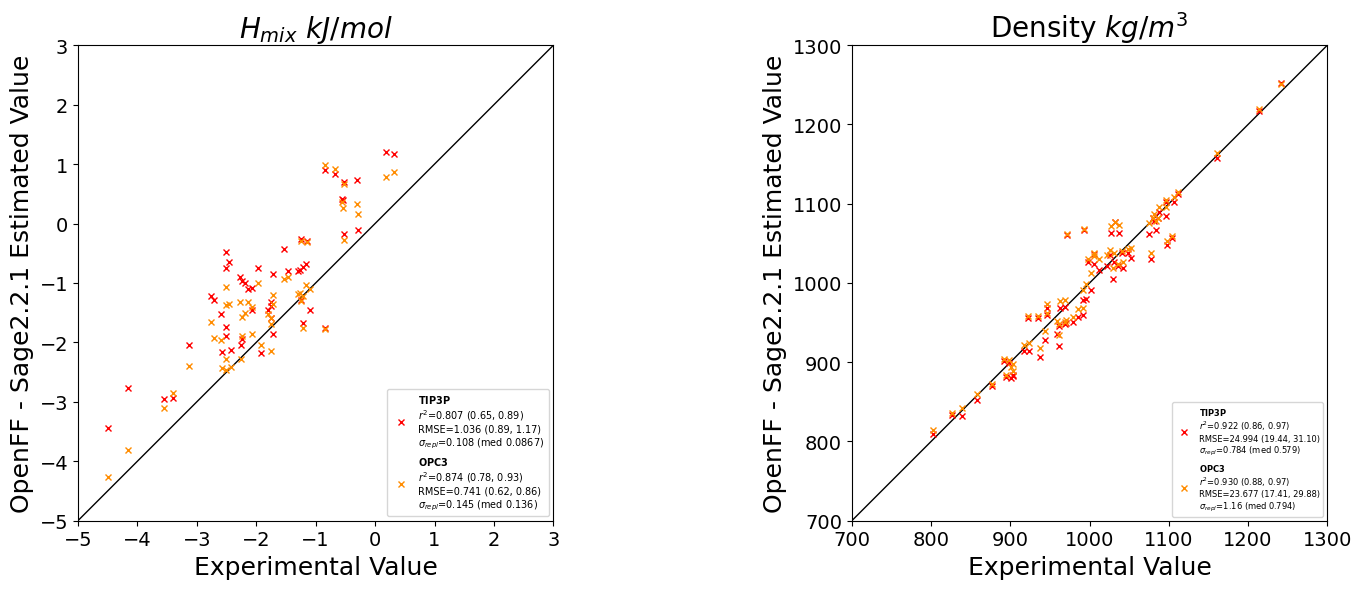

In [18]:
plot_results_multi_model(results_221, ["TIP3P","OPC3"], func="both", ff_label=f'OpenFF - {force_field[0]}' ,save_prefix=f"hmix_dens_bnmrk_{force_field[0]}")

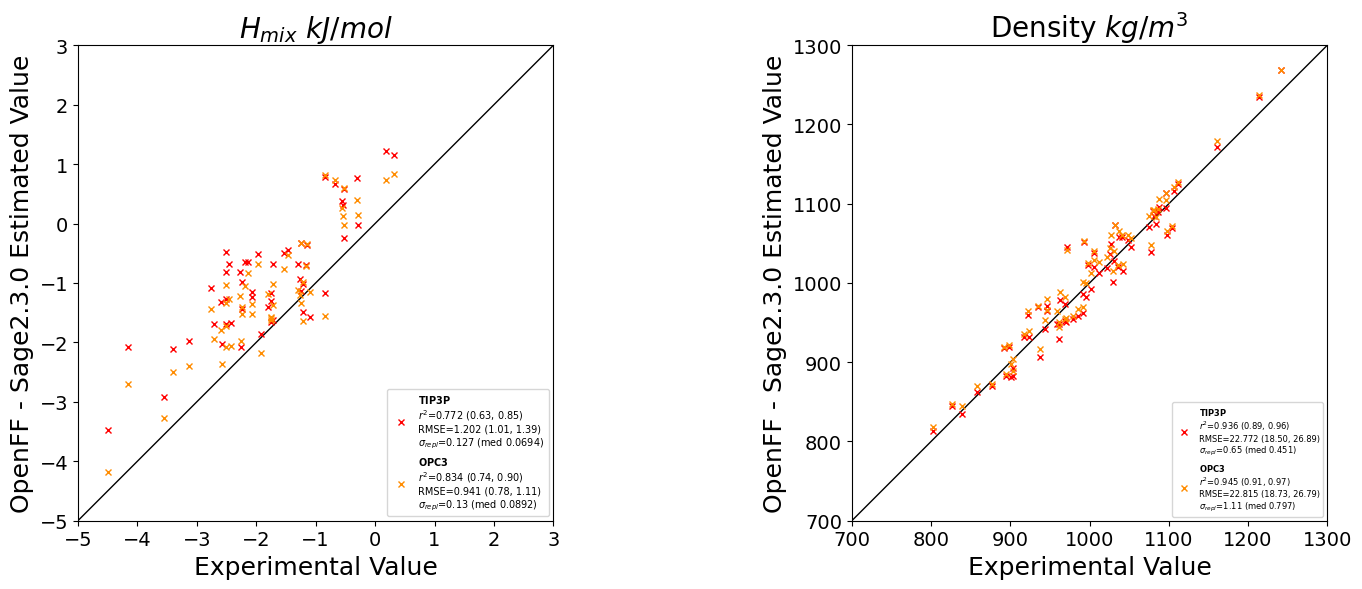

In [19]:
plot_results_multi_model(results_230, ["TIP3P","OPC3"], func="both", ff_label=f'OpenFF - {force_field[1]}' ,save_prefix=f"hmix_dens_bnmrk_{force_field[1]}")

## RMSE

In [22]:
def _fetch_rmse_and_bounds(results_all, model_display, property_name):
    """
    Fetch RMSE and asymmetric error bars for a model/property from results_all.

    Returns (rmse, err_low, err_up) where:
      err_low = rmse - lb
      err_up  = ub - rmse
    Returns None if missing.

    Prefers new keys:
      "{prefix}:{prop}-RMSE_Aggregate_vs_Experimental"
      "{prefix}:{prop}-RMSE_Aggregate_CI"
    Falls back to legacy:
      "{prefix}:{prop}-Stats" -> ['rmse'], ['rmse_bounds'] = (lb, ub)
    """
    prefix = RESULTS_PREFIX.get(model_display, model_display)

    # --- 1) Try new fields first
    key_rmse = f"{prefix}:{property_name}-RMSE_Aggregate_vs_Experimental"
    key_ci   = f"{prefix}:{property_name}-RMSE_Aggregate_CI"
    try:
        rmse = float(results_all[key_rmse])
        lb, ub = results_all[key_ci]
        lb = float(lb); ub = float(ub)
        if not (np.isfinite(rmse) and np.isfinite(lb) and np.isfinite(ub)):
            raise ValueError("non-finite values")
        return rmse, max(rmse - lb, 0.0), max(ub - rmse, 0.0)
    except Exception:
        pass

    # --- 2) Fallback to legacy Stats
    try:
        stats = results_all[f"{prefix}:{property_name}-Stats"]
        rmse = float(stats["rmse"])
        lb, ub = stats["rmse_bounds"]
        lb = float(lb); ub = float(ub)
        if not (np.isfinite(rmse) and np.isfinite(lb) and np.isfinite(ub)):
            raise ValueError("non-finite values")
        return rmse, max(rmse - lb, 0.0), max(ub - rmse, 0.0)
    except Exception:
        return None


def plot_rmse_by_model(
    results_all,
    properties=('EnthalpyOfMixing', 'Density'),
    water_models=None,                  # e.g. ['TIP3P','OPC']; None -> DEFAULT_MODELS
    ff_label='Sage 2.2.1',
    color_map=None,                     # dict model->color; defaults to DEFAULT_COLORS
    ylabel_map=None,                    # dict property->ylabel; defaults below
    save_prefix=None,                   # e.g. 'rmse_', files: 'rmse_EnthalpyOfMixing_rmse_all.png'
    show=True
):
    if water_models is None:
        water_models = waters.copy()
    if color_map is None:
        color_map = DEFAULT_COLORS.copy()
    if ylabel_map is None:
        ylabel_map = {
            'EnthalpyOfMixing': r'RMSE, kJ/mol',
            'Density': r'RMSE, $kg/m^{3}$',
        }

    for prop in properties:
        labels, yvals, err_low, err_up, bar_colors = [], [], [], [], []

        for mdl in water_models:
            fetched = _fetch_rmse_and_bounds(results_all, mdl, prop)
            if fetched is None:
                # print(f"[warn] Missing {mdl}:{prop}")
                continue
            rmse, lo, hi = fetched
            labels.append(mdl)
            yvals.append(rmse)
            err_low.append(lo)
            err_up.append(hi)
            bar_colors.append(color_map.get(mdl, 'gray'))

        if not labels:
            print(f"[info] No data available for property '{prop}' with the selected models.")
            continue

        # Matplotlib expects yerr as [lower, upper] distances from the mean
        yerr = np.vstack([err_low, err_up])

        fig, ax = plt.subplots()
        ax.bar(labels, yvals, yerr=yerr, capsize=10, color=bar_colors)

        ax.set_ylabel(ylabel_map.get(prop, 'RMSE'), fontsize=MEDIUM_SIZE)
        ax.set_title(f'{prop} RMSE - {ff_label}', fontsize=BIGGER_SIZE)
        ax.tick_params(axis='y', labelsize=SMALL_SIZE)
        ax.tick_params(axis='x', labelsize=SMALL_SIZE - 3)

        fname = f"{(save_prefix or '')}{prop.replace(' ', '_')}_rmse_all.png"
        plt.savefig(fname, bbox_inches='tight', dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)


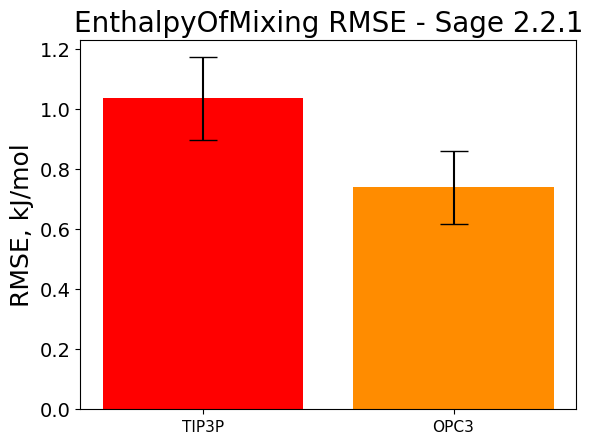

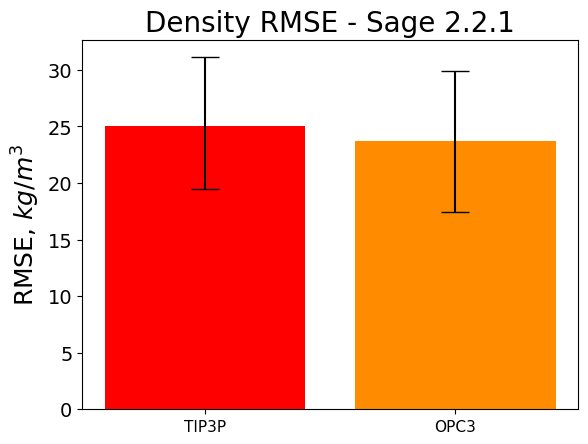

In [23]:
plot_rmse_by_model(
    results_221,
    properties=('EnthalpyOfMixing','Density'),
    water_models=['TIP3P','OPC','OPC3'],
    ff_label='Sage 2.2.1',
    ylabel_map={
        'EnthalpyOfMixing': r'RMSE, kJ/mol',
        'Density': r'RMSE, $kg/m^{3}$',
    },
    save_prefix='',                       # files: EnthalpyOfMixing_rmse_all.png, Density_rmse_all.png
    show=True
)


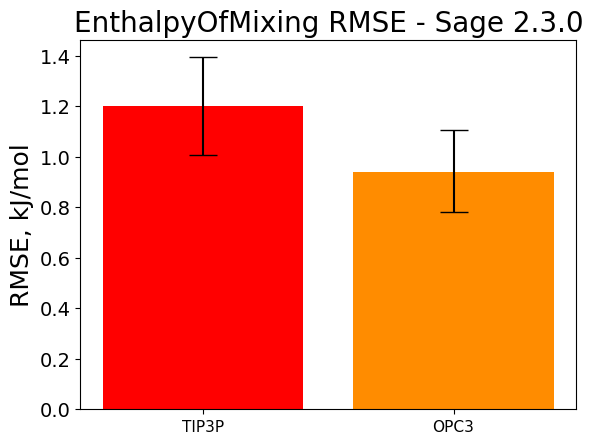

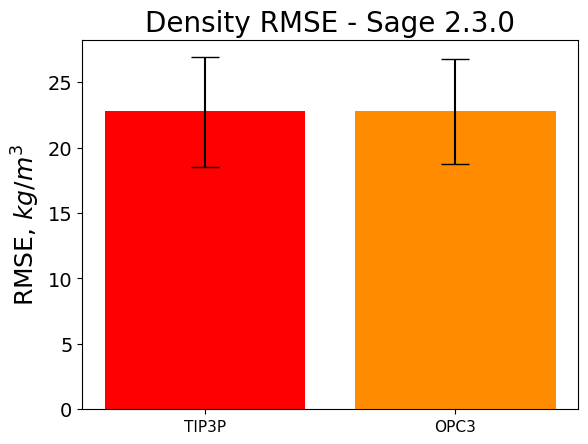

In [24]:
plot_rmse_by_model(
    results_230,
    properties=('EnthalpyOfMixing','Density'),
    water_models=['TIP3P','OPC','OPC3'],
    ff_label='Sage 2.3.0',
    ylabel_map={
        'EnthalpyOfMixing': r'RMSE, kJ/mol',
        'Density': r'RMSE, $kg/m^{3}$',
    },
    save_prefix='',                       # files: EnthalpyOfMixing_rmse_all.png, Density_rmse_all.png
    show=True
)

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _replicate_rmses(results_all, model, prop):
    """Return list of per-replicate RMSEs for a model/prop.
       Tries new key first, falls back to aggregate-only (single value)."""
    prefix = RESULTS_PREFIX.get(model, model)
    k = f"{prefix}:{prop}-RMSE_PerReplicate_vs_Experimental"
    if k in results_all:
        arr = results_all[k]
        vals = [float(x) for x in arr if x is not None and np.isfinite(x)]
        if vals:
            return vals
    # fallback: use aggregate rmse (no stdev possible)
    try:
        stats = results_all[f"{prefix}:{prop}-Stats"]
        val = float(stats["rmse"])
        return [val] if np.isfinite(val) else []
    except Exception:
        return []

def _resolve_colors(labels, color_map):
    """Return list of colors matching labels, with safe fallbacks."""
    if color_map is None:
        try:
            # If user/global DEFAULT_COLORS exists, use it
            cmap = DEFAULT_COLORS.copy()
        except NameError:
            # fallback to tab10 cycling
            tab = plt.cm.get_cmap("tab10")
            return [tab(i % 10) for i in range(len(labels))]
    else:
        cmap = color_map
    return [cmap.get(m, "gray") for m in labels]

def plot_mean_sd_rmse(
    results_all,
    properties=("EnthalpyOfMixing","Density"),
    water_models=None,                 # e.g. ("TIP4P_Ew","OPC","OPC3","GOPAL")
    ff_label="Sage 2.3.0",
    ylabel_map=None,
    save_prefix="rmse_mean_sd_",
    show=True,
    # --- color options (RESTORED) ---
    color_map=None,                    # dict: model -> color (defaults to DEFAULT_COLORS or tab10)
    bar_edgecolor=None,                # e.g. "black"
    dot_alpha=0.65,
    # --- zoom options ---
    zoom_y=None,                       # None, (ymin,ymax), or dict {prop: (ymin,ymax)}
    inset_zoom=False,
    inset_height="45%",
    inset_loc="upper right",
    inset_margin=0.05
):
    """
    Plot mean±SD of per-replicate RMSEs per model. Bars are colored by model.
    Zoom options:
      - zoom_y=(ymin, ymax) or dict per property for main axis
      - inset_zoom=True for a tight inset around mean±SD
    """
    if water_models is None:
        try:
            water_models = DEFAULT_MODELS
        except NameError:
            water_models = ("TIP4P_Ew","OPC","OPC3","GOPAL")

    if ylabel_map is None:
        ylabel_map = {
            "EnthalpyOfMixing": r"RMSE, kJ/mol",
            "Density": r"RMSE, $kg/m^{3}$",
        }

    def _y_limits_for(prop):
        if isinstance(zoom_y, dict):
            return zoom_y.get(prop)
        return zoom_y if zoom_y is not None else None

    for prop in properties:
        labels, means, sds = [], [], []
        swarm_x, swarm_y, swarm_c = [], [], []

        # Collect
        for i, mdl in enumerate(water_models):
            vals = _replicate_rmses(results_all, mdl, prop)
            if not vals:
                continue
            labels.append(mdl)
            means.append(float(np.mean(vals)))
            sds.append(float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0)
            for v in vals:
                swarm_x.append(i)
                swarm_y.append(v)

        if not labels:
            print(f"[info] No data for {prop}.")
            continue

        # Colors per model
        bar_colors = _resolve_colors(labels, color_map)
        # Assign dot colors matching their model
        label_to_color = {m: c for m, c in zip(labels, bar_colors)}
        for i in range(len(swarm_x)):
            mdl = labels[swarm_x[i]]
            swarm_c.append(label_to_color.get(mdl, "gray"))

        x = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(0.9*len(labels)+3, 4.5))

        # bars
        ax.bar(x, means, yerr=sds, capsize=8, color=bar_colors,
               edgecolor=bar_edgecolor)

        # jittered replicate dots
        # if swarm_y:
        #     jitter = (np.random.rand(len(swarm_x)) - 0.5) * 0.2
        #     ax.scatter(x=np.array(swarm_x)+jitter, y=swarm_y,
        #                alpha=dot_alpha, s=30, zorder=3, c=swarm_c)

        ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0, fontsize=MEDIUM_SIZE)
        ax.set_ylabel(ylabel_map.get(prop, "RMSE"), fontsize=MEDIUM_SIZE)
        ax.set_title(f"{prop} — mean±SD across replicates ({ff_label})", fontsize=MEDIUM_SIZE)
        ax.grid(axis="y", alpha=0.2)

        # main zoom
        ylims = _y_limits_for(prop)
        if ylims is not None:
            ax.set_ylim(*ylims)

        # inset zoom
        if inset_zoom and len(means) > 0:
            axy = inset_axes(ax, width="40%", height=inset_height, loc=inset_loc, borderpad=1.0)
            axy.bar(x, means, yerr=sds, capsize=5, color=bar_colors, edgecolor=bar_edgecolor)
            axy.set_xticks(x); axy.set_xticklabels([])
            mmin = np.min(np.array(means) - np.array(sds))
            mmax = np.max(np.array(means) + np.array(sds))
            yrng = max(mmax - mmin, 1e-9)
            pad = inset_margin * yrng
            axy.set_ylim(mmin - pad, mmax + pad)
            axy.grid(axis="y", alpha=0.2)

        fname = f"{save_prefix}{prop.replace(' ','_')}.png"
        plt.savefig(fname, dpi=200, bbox_inches="tight")
        if show:
            plt.show()
        else:
            plt.close(fig)


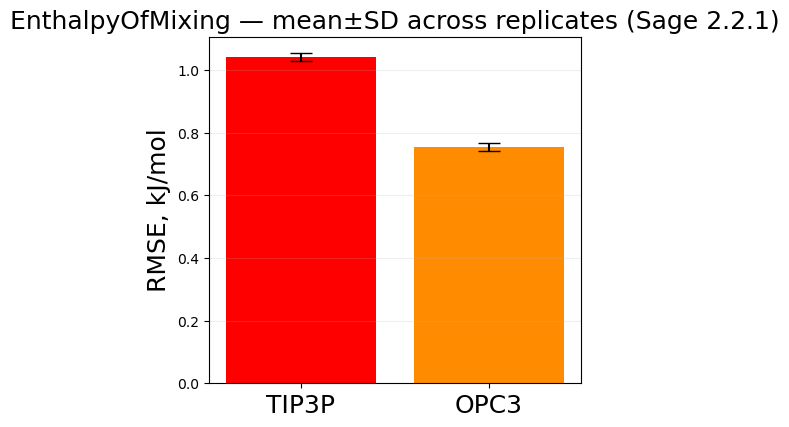

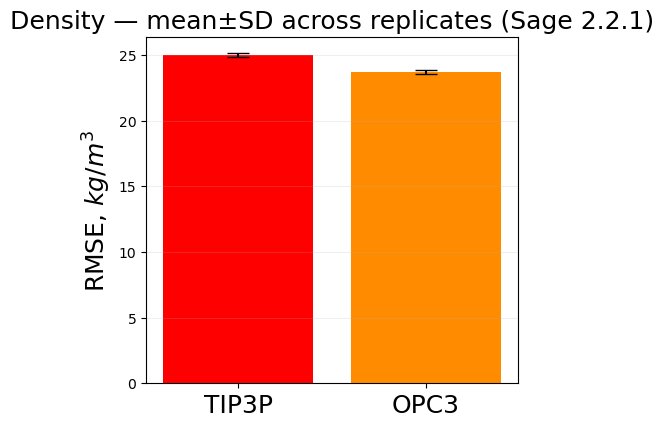

In [33]:
plot_mean_sd_rmse(
    results_221,
    properties=('EnthalpyOfMixing','Density'),
    water_models=['TIP3P','OPC3'],
    ff_label='Sage 2.2.1',
    save_prefix=f'RMSE-{force_field[0]}',                       # files: EnthalpyOfMixing_rmse_all.png, Density_rmse_all.png
    show=True,
    color_map=DEFAULT_COLORS
    # zoom_y={"EnthalpyOfMixing": (0.7, 1.1),
    #                       "Density": (23, 26)}
                          )

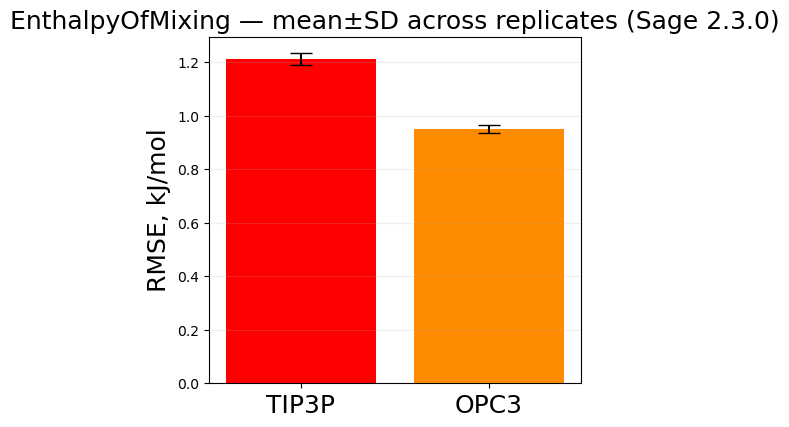

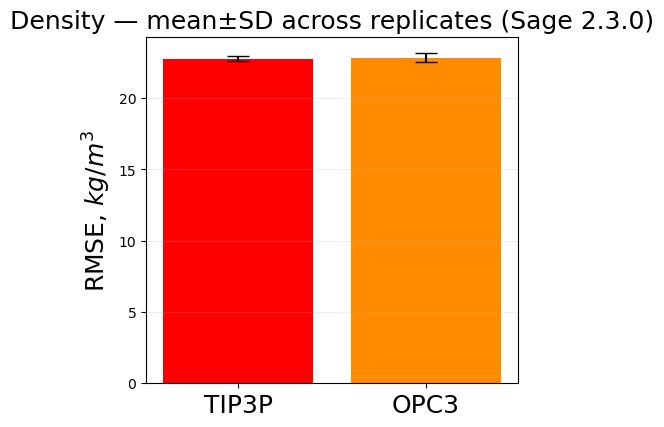

In [32]:
plot_mean_sd_rmse(
    results_230,
    properties=('EnthalpyOfMixing','Density'),
    water_models=['TIP3P','OPC3'],
    ff_label='Sage 2.3.0',
    save_prefix=f'RMSE-{force_field[1]}',                       # files: EnthalpyOfMixing_rmse_all.png, Density_rmse_all.png
    show=True,
    color_map=DEFAULT_COLORS
    # zoom_y={"EnthalpyOfMixing": (0.7, 1.1),
    #                       "Density": (23, 26)}
                          )
